# Práctica 2: Introducción a PyTorch

## a) Calculando el gradiente mediante Autograd

En primer lugar, vamos a calcular del gradiente para el perceptrón simple con función de activación sigmoidea que vimos en la teoría. Pero esta vez, en lugar de realizar manualmente el proceso de backpropagation, vamos a usar el módulo `autograd` de PyTorch.

La función $f(x, w)$ a la cual queremos encontrarle el gradiente es:

> $f(\mathbf{x}, \mathbf{w}) = \frac{1}{1 + e^{2-(w_0 x_0 + w_1 x_1 + w_2)}}$

Definimos entonces la función utilizando `torch.tensor` (recordar usar el parámetro `requires_grad = True` para que PyTorch guarde los gradientes) y realizamos la pasada "forward" para los siguientes valores de x y w:

> $\mathbf{x} = (-1, -2)$

> $\mathbf{w} = (2, -3, -3)$



In [2]:
import torch
#defini e como la constante de euler

e = torch.tensor([2.718281828465590], requires_grad=False) #con requires_grad = False Pytorch no guarda los gradientes, por default su valor es Fals

x = torch.tensor([-1., -2.], requires_grad=True) #con required_grad = True Pytorch guarda los gradientes, son los datos de entrada

w = torch.tensor([2., -3., -3.], requires_grad=True) #los pesos 

f = 1 / (1+e[0]**(2-(w[0]*x[0]+w[1]*x[1]+w[2]))) #es el valor de la función de activación dados x y w

print(f)


tensor(0.2689, grad_fn=<MulBackward0>)


Ahora, utilizando la función `f.backward()` computamos los gradientes $\frac{\partial f}{ \partial \mathbf{x}}$ y $\frac{\partial f}{ \partial \mathbf{w}}$

In [4]:
f.backward() #calcula los gradientes de f con respecto a x y w

In [6]:
print("Gradiente df/dx = " + str(x.grad))
print("Gradiente df/dw = " + str(w.grad)) #imprimimos los gradientes de f con respecto a x y w

Gradiente df/dx = tensor([ 0.3932, -0.5898])
Gradiente df/dw = tensor([-0.1966, -0.3932,  0.1966])


## b) Minimizando una función con Gradient Descent

Ahora, vamos a implementar usar el algorítmo de gradiente descendiente (utilizando Autograd para computar el gradiente) para minimizar la función cuadrática $$f(x) = 2x^2 + x + 4$$

Utilizaremos la implementación `torch.optim.SGD` de gradiente descendiente.



C:\Users\Goico\AppData\Local\Temp\ipykernel_12676\1148398619.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor( torch.rand(1) , requires_grad=True) #peso a optimizar


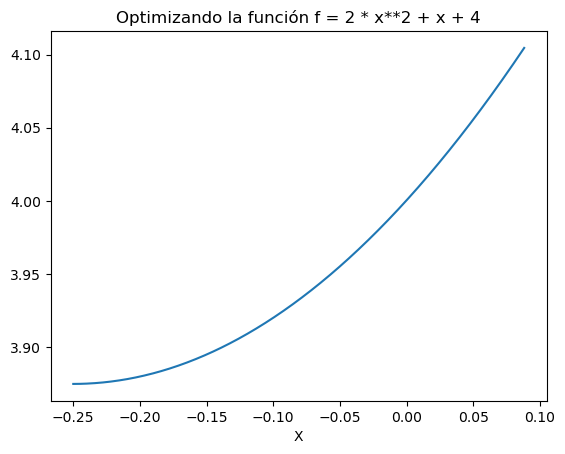

In [29]:
import matplotlib.pyplot as plt

# Definir la variable que será el parámetro a optimizar
#definir x con un valor inicial aleatorio

x = torch.tensor( torch.rand(1) , requires_grad=True) #peso a optimizar

# Definir el optimizador, indicando el parámetro a optimizar y el learning rate
optimizer = torch.optim.SGD([x], lr=0.0005) #optimizador de gradiente descendiente

# Acumuladores que usaremos para guardar los valores sucesivos de x, y
f_values = []
x_values = []

# Loop de optimización
for i in range(4000):

    # Setemos en 0 los gradientes de todos los elementos
    optimizer.zero_grad() #inicializa los gradientes de todos los elementos en 0 porque si no se acumulan en cada paso de optimización 

    # Pasada forward: ejecutar la función a minimizar
    f = 2 * x**2 + x + 4 #computa el valor de f con el x que tenemos

    #print("X = " + str(x) + ", f(x) = " + str(f))

    # Pasada backward: computar los gradientes
    f.backward()

    # Actualizar los pesos dando un paso de gradiente descendiente
    optimizer.step()

    # Guardar los valores para luego plotearlos
    f_values.append(f.data.item())
    x_values.append(x.data.item())

# Ploteo los valores
plt.title("Optimizando la función f = 2 * x**2 + x + 4")
plt.xlabel("X")
plt.plot(x_values,f_values)



In [20]:
x_values[-1] #valor donde f alcanza el mínimo

-0.24967755377292633

# c) Implementando un MLP en PyTorch para predicción del procentaje de grasa corporal

Contamos con una base de datos [1] de 252 mediciones del porcentaje de grasa corporal de 252 personas diferentes, el cual puede ser estimado mediante otras características, como la edad, el peso, y mediciones en diferentes partes del cuerpo. A partir de estos datos se pretende desarrollar un sistema que permita predecir dicho porcentaje a partir de las características.

[1]: Olson, R.S., La Cava, W., Orzechowski, P. et al. PMLB: a large benchmark suite for machine learning evaluation and comparison. BioData Mining 10, 36 (2017). https://epistasislab.github.io/pmlb/profile/560_bodyfat.html

Antes de comenzar, vamos a instalar el paquete de Python que contiene la base de datos:

In [21]:
pip install pmlb

Note: you may need to restart the kernel to use updated packages.


Ahora vamos a generar un histograma de todas las mediciones del porcentaje con todos los datos disponibles:

Fila de ejemplo:
['Density', 'Age', 'Weight', 'Height', 'Neck', 'Chest', 'Abdomen', 'Hip', 'Thigh', 'Knee', 'Ankle', 'Biceps', 'Forearm', 'Wrist', 'target']
[  1.0708  23.     154.25    67.75    36.2     93.1     85.2     94.5
  59.      37.3     21.9     32.      27.4     17.1   ]


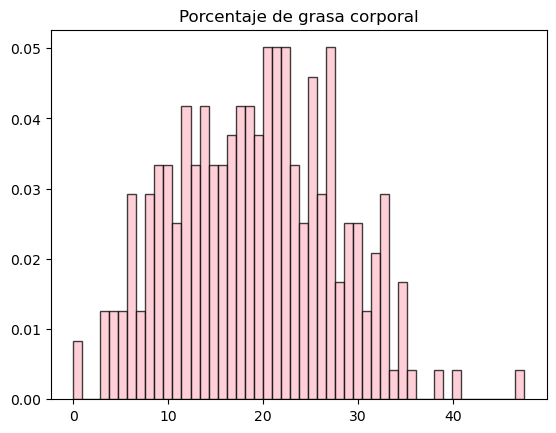

In [26]:
import matplotlib.pyplot as plt
import numpy as np
from pmlb import fetch_data

# Importamos el dataset
body_fat = fetch_data('560_bodyfat')
body_fat.describe()

# Extraigo los datos (features) y los porcentajes (etiquetas a predecir)
data = body_fat.loc[:, body_fat.columns != 'target'].to_numpy()
percentages = body_fat.loc[:, body_fat.columns == 'target'].to_numpy()

data = data.astype(np.float32)
percentages = percentages.astype(np.float32)

print("Fila de ejemplo:")
print(list(body_fat.columns))
print(data[0,:])

# Dibujo un histograma del porcentaje de grasa corporal usando todos los datos
_ = plt.hist(percentages, 50, density=True, facecolor='pink', alpha=0.75, edgecolor='black')
_ = plt.title("Porcentaje de grasa corporal")


Particionamos los datos en entrenamiento y prueba usando la función `sklearn.model_selection.train_test_split`

In [28]:
from sklearn.model_selection import train_test_split

 # Particiono los datos en entrenamiento y prueba usando el método de scikitlearn
X_train, X_test, y_train, y_test = train_test_split( data ,percentages, test_size=0.33, random_state=42)

Ahora implementaremos en PyTorch un Perceptrón multicapa que usaremos como regresor del porcentaje de grasa corporal (ejemplo basado en el curso de [RPI](https://rpi.analyticsdojo.com/)).

El perceptrón deberá contar con 3 capas:
- Las dos primeras con 200 neuronas, y deberán usar la función de activación ReLU.
- La última con una única neurona cuya salida sea un valor escalar que corresponda al porcentaje de grasa corporal estimado de la persona, que no deberá utilizar ninguna función de activación.

Algunas clases de PyTorch que resultarán útiles para implementar el modelo, son:
- `torch.nn.Linear`: Implementa una capa totalmente conectada. Es necesario especificarle el número de parámetros de entrada y de salida.
- `torch.nn.functional.relu`: Implementa la función de activación ReLU.

Además, utilizaremos el optimizador `torch.optim.Adam` y la función de pérdida `torch.nn.MSELoss` (error cuadrático medio).






Epoch 100, loss = 20.5352
Epoch 200, loss = 16.6284
Epoch 300, loss = 18.6915
Epoch 400, loss = 15.7869
Epoch 500, loss = 13.3572
Epoch 600, loss = 12.2306
Epoch 700, loss = 11.7611
Epoch 800, loss = 13.4734
Epoch 900, loss = 9.27655
Epoch 1000, loss = 9.05196
Epoch 1100, loss = 8.14942
Epoch 1200, loss = 7.55466
Epoch 1300, loss = 5.52184
Epoch 1400, loss = 5.56429
Epoch 1500, loss = 3.03345
Epoch 1600, loss = 2.12406
Epoch 1700, loss = 5.26966
Epoch 1800, loss = 1.1591
Epoch 1900, loss = 1.49002
Epoch 2000, loss = 1.17979
Epoch 2100, loss = 0.616865
Epoch 2200, loss = 0.815916
Epoch 2300, loss = 0.816531
Epoch 2400, loss = 0.573689
Epoch 2500, loss = 0.699093
Epoch 2600, loss = 0.459025
Epoch 2700, loss = 0.569738
Epoch 2800, loss = 0.14837
Epoch 2900, loss = 1.50498
Epoch 3000, loss = 0.334205
Epoch 3100, loss = 0.541252
Epoch 3200, loss = 0.63647
Epoch 3300, loss = 0.453788
Epoch 3400, loss = 0.216682
Epoch 3500, loss = 0.146866
Epoch 3600, loss = 0.673634
Epoch 3700, loss = 0.0607

Text(0.5, 1.0, 'Función de pérdida durante el entrenamiento')

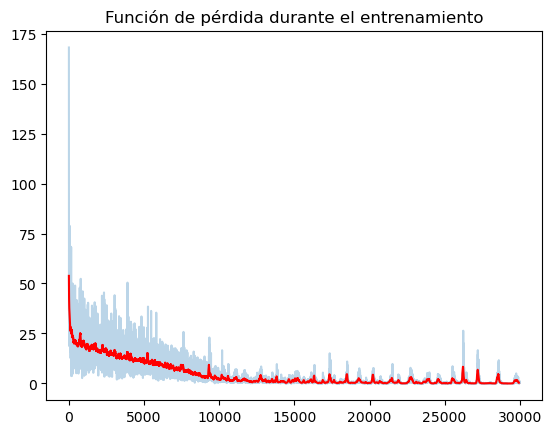

In [40]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

# Tamaño del batch de entrenamiento
batch_size = 32 #vamos viendo de a partes el entrenamiento

# Tasa de aprendizaje inicial para el gradiente descendente
learning_rate = 1e-3 #0.001

class Net(torch.nn.Module):
    def __init__(self, input_features, size_hidden, n_output):
        super(Net, self).__init__()
        self.hidden1 = nn.Linear(input_features, size_hidden)
        self.hidden2 = nn.Linear(size_hidden, size_hidden)
        self.out = nn.Linear(size_hidden, n_output)

    def forward(self, x):
        x = torch.nn.functional.relu(self.hidden1(x))
        x = torch.nn.functional.relu(self.hidden2(x))
        x = self.out(x)
        return x

# Definimos el modelo del perceptrón
input_features = 14 # 14 atributos
size_hidden = 200 # Número de neuronas en la capa oculta
n_output = 1 # Número de neuronas en la capa de salida

net = Net(input_features, size_hidden, n_output)



# Construimos el optimizador, y le indicamos que los parámetros a optimizar
# son los del modelo definido: net.parameters()

optimizer = torch.optim.Adam(net.parameters() , lr=learning_rate)

# Definimos también la función de pérdida a utilizar
criterion = nn.MSELoss() #funcion LOSS

# Creamos el objeto dataset que empaqueta los array de numpy para que puedan ser leidos por PyTorch
dataset = TensorDataset(torch.from_numpy(X_train).clone(), torch.from_numpy(y_train).clone())

# Creamos un loader iterable indicandole que debe leer los datos a partir de
# del dataset creado en el paso anterior. Este objeto puede ser iterado
# y nos devuelve de a un batch (x, y).
loader = DataLoader(dataset=dataset, batch_size=batch_size, shuffle=True)

# Número de épocas
num_epochs = 5000 #una epoca es ver una vez todo mi dataset, esto lo hago 5000 veces en este caso
# 5000 * N/32 es la cantidad de pasos del gradiente

# Lista en la que iremos guardando el valor de la función de pérdida en cada etapa de entrenamiento
loss_list = []

# Bucle de entrenamiento
for i in range(num_epochs):

    total_loss = 0.0
    for x, y in loader:
        # Seteo en cero los gradientes de los parámetros a optimizar
        optimizer.zero_grad()

        # Realizo la pasada forward por la 
        outputs = net(x)
        loss = criterion(outputs, y.view(-1, 1))

        # Realizo la pasada backward por la red
        loss.backward()

        # Actualizo los pesos de la red con el optimizador
        optimizer.step()

        # Me guardo el valor actual de la función de pérdida para luego graficarlo
        loss_list.append(loss.data.item())

        # Acumulo la loss del minibatch
        total_loss += loss.item() * y.size(0)

    # Normalizo la loss total
    total_loss/= len(loader.dataset)

    # Muestro el valor de la función de pérdida cada 100 iteraciones
    if i > 0 and i % 100 == 0:
        print('Epoch %d, loss = %g' % (i, total_loss))

# Muestro la lista que contiene los valores de la función de pérdida
# y una versión suavizada (rojo) para observar la tendencia
plt.figure()
loss_np_array = np.array(loss_list)
plt.plot(loss_np_array, alpha = 0.3)
N = 60
running_avg_loss = np.convolve(loss_np_array, np.ones((N,))/N, mode='valid')
plt.plot(running_avg_loss, color='red')
plt.title("Función de pérdida durante el entrenamiento")

MSE medio en training: 0.5925816
MSE medio en test: 39.702156


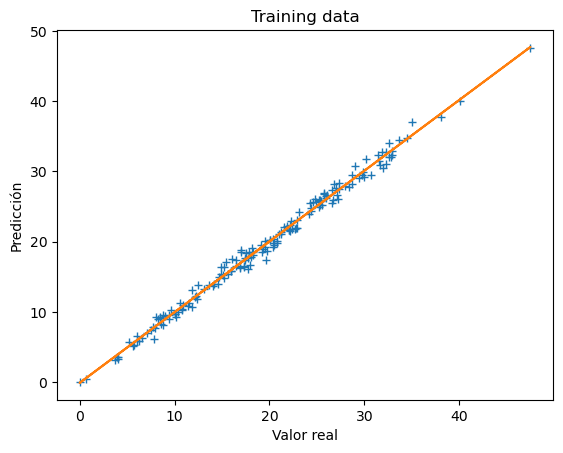

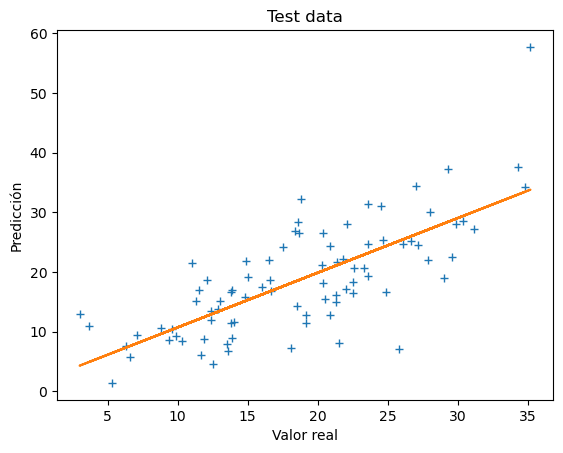

In [41]:
from sklearn.linear_model import LinearRegression
from numpy.linalg import norm

# Definimos un método para mostrar las predicciones como un scatter plot
# y graficamos la recta de regresión para esos datos.
def plotScatter(x_data, y_data, title, fit_line=True):
  plt.figure()

  plt.plot(x_data, y_data, '+')
  plt.xlabel('Valor real')
  plt.ylabel('Predicción')
  plt.title(title)

  if fit_line:
    X, Y = x_data.reshape(-1,1), y_data.reshape(-1,1)
    plt.plot( X, LinearRegression().fit(X, Y).predict(X) )

# Dibujamos el ground truth vs las predicciones en los datos de entrenamiento
py = net(torch.FloatTensor(X_train))
y_pred_train = py.cpu().detach().numpy()
plotScatter(y_train, y_pred_train, "Training data")

# Dibujamos el ground truth vs las predicciones en los datos de test
py = net(torch.FloatTensor(X_test))
y_pred_test = py.cpu().detach().numpy()
plotScatter(y_test, y_pred_test, "Test data")

print ("MSE medio en training: " + str(((y_train - y_pred_train)**2).mean()))
print ("MSE medio en test: " + str(((y_test - y_pred_test)**2).mean()))

# Entregable
1. Encontrar el mínimo de la función *f* definida en el apartado b). Para ello, deberán encontrar primero la derivada *f'(x)* de forma analítica, y utilizarla para computar el mínimo de la función. Posteriormente, deberán corrobarar que el valor coincida con el que obtuvieron optimizando la función con gradiente descendiente.

2. Compara el rendimiento de 3 perceptrones multicapa que varíen en la cantidad de neuronas en sus capas intermedia. Probar colocando 2, 10 y 200 neuronas en dichas capas, al entrenar los perceptrones durante 5000 épocas. Mostrar los resultados utilizando:

* los gráficos de dispersión con la recta de regresión
* el error medio en los datos de entrenamiento y test

  Analizar la relación entre dichos resultados y la cantidad de neuronas que posee el perceptrón.
